In [7]:
# Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [8]:
# Input show title to find the imdb id

# Variables-main
show = 'The Office'
save_folder = 'show_ratings'

# Search url
url_search = 'https://www.imdb.com/find?q='

# Put the search term in the url_search     example: imdb.com/find?q=breaking+bad
for word in show.split():
    if url_search[-1] == '=':
        url_search = url_search + word
    else:
        url_search = url_search+'+'+word

# Parse the get request
get_search = requests.get(url_search)
soup_search = BeautifulSoup(get_search.text, 'html.parser')

# Get the imdb_id
find_search = soup_search.find('tr', attrs={'class':'findResult odd'})
imdb_id = find_search.find('a')['href'].split('/')[2]
show = find_search.find_all('a')[1].text
print(show)
print(imdb_id)

The Office
tt0386676


In [9]:
# Use the imdb id to find the latest season available
get_home = requests.get('https://www.imdb.com/title/'+imdb_id)
soup_home = BeautifulSoup(get_home.text, 'html.parser')
#soup_home

# find the latest season available
find_home = soup_home.find('div', attrs = {'class': 'seasons-and-year-nav'})
max_season =  int(find_home.find('a').text)
print(max_season)

9


In [10]:
# Find the ratings for episodes in each season
records = []
for current_season in range(1,max_season+1):
    get_season = requests.get('https://www.imdb.com/title/'+imdb_id+'/episodes?season='+str(current_season))
    soup_season = BeautifulSoup(get_season.text, 'html.parser')
    
    # List of ratings
    find_season = soup_season.find_all('span', attrs={'class':'ipl-rating-star__rating'})[::23]     #ratings occur in every 23rd item
    
    episode = 1
    for rating in find_season:
        records.append((show, current_season, episode, float(rating.text)))
        episode += 1
        
# Add records to DataFrame 
df = pd.DataFrame(records, columns=['show', 'season', 'episode', 'rating'])     

# Num of season and episodes determine size of plot
max_season = df.season.max()    
max_episode = df.episode.max()

print(df.episode.count())
df

188


,show,season,episode,rating
0,The Office,1,1,7.5
1,The Office,1,2,8.3
2,The Office,1,3,7.8
3,The Office,1,4,8.1
4,The Office,1,5,8.4
...,...,...,...,...
183,The Office,9,19,8.0
184,The Office,9,20,8.0
185,The Office,9,21,9.0
186,The Office,9,22,9.5


In [11]:
# Pivot Table
df_pivot = df.pivot(index='season',columns='episode',values='rating')
df_pivot

episode,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
season,,,,,,,,,,,,,,,,,,,,,
1,7.5,8.3,7.8,8.1,8.4,7.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.7,8.2,8.4,8.4,8.1,8.2,8.6,8.2,8.4,8.9,...,8.5,8.3,8.1,8.4,8.7,9.4,NaN,NaN,NaN,NaN
3,9.0,8.2,8.5,8.0,8.1,7.9,8.6,8.7,8.3,8.8,...,8.5,9.0,8.8,8.7,8.8,9.2,9.3,NaN,NaN,NaN
4,8.8,8.3,8.4,8.7,8.8,8.5,8.2,8.7,9.5,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8.8,8.3,8.0,8.1,8.1,8.5,8.2,8.6,8.8,8.4,...,8.7,8.3,8.4,8.3,8.7,8.7,9.2,8.3,8.7,9.0
6,8.8,8.1,8.0,9.4,9.4,7.6,8.6,8.2,8.1,8.7,...,8.4,8.5,7.7,7.8,8.6,7.8,8.0,8.2,7.8,8.0
7,8.4,8.2,8.2,7.9,7.8,8.2,7.4,7.9,7.7,8.2,...,7.5,9.3,7.8,9.0,9.8,7.6,8.7,8.8,NaN,NaN
8,8.1,8.1,7.3,8.1,7.6,7.7,7.7,6.9,7.7,8.0,...,7.8,7.8,6.6,7.1,7.1,7.0,7.6,7.7,NaN,NaN
9,7.6,7.1,7.4,7.8,7.0,7.7,7.6,7.8,8.4,7.6,...,7.5,8.0,8.0,8.0,9.0,9.5,9.8,NaN,NaN,NaN


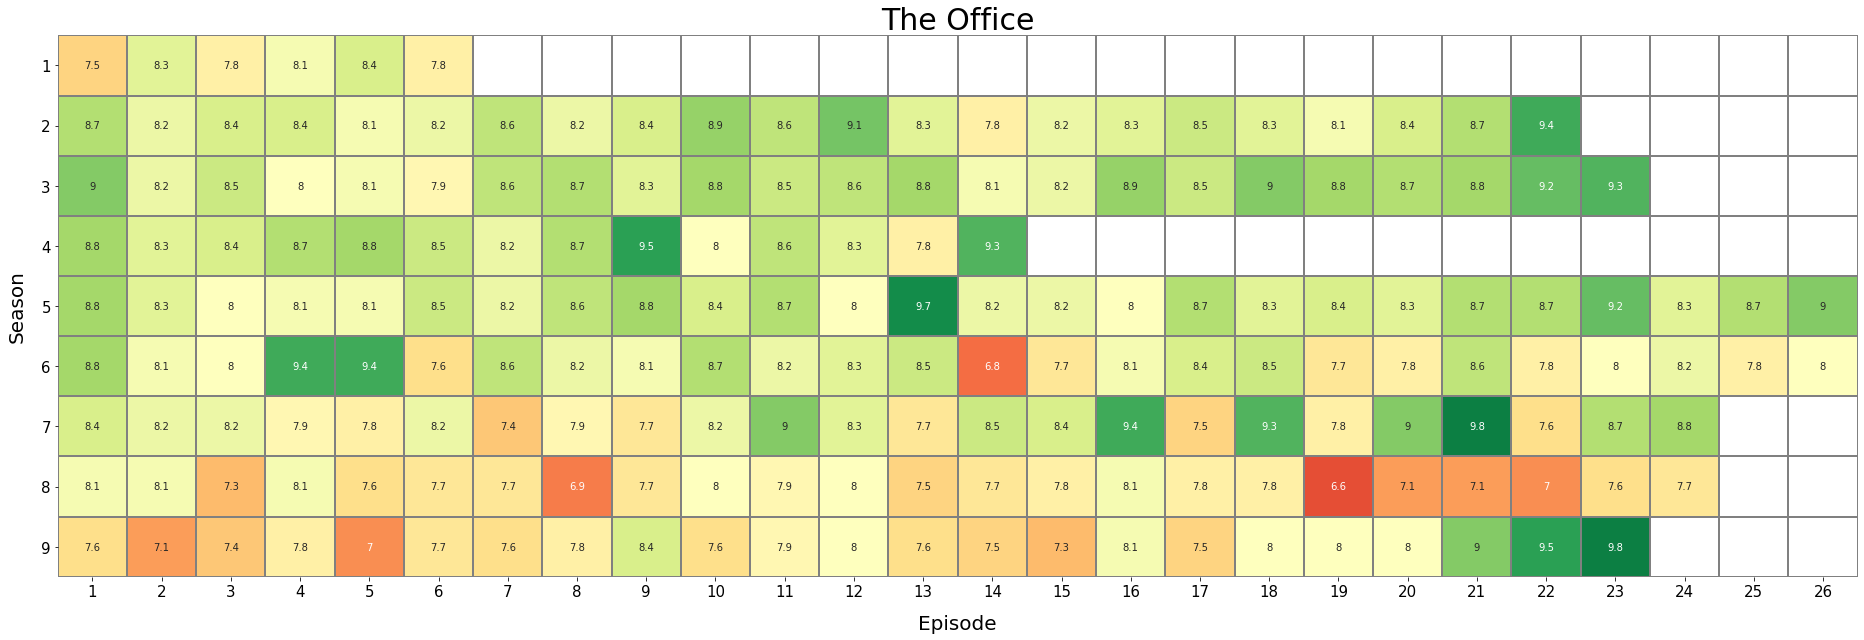

In [12]:
# Create a directory to store results
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)

# Plot
f, ax = plt.subplots(figsize=(max_episode, max_season))
ax = sns.heatmap(df_pivot,vmin=6,vmax=10, annot=True,linewidths=1, cmap='RdYlGn', linecolor='gray', cbar=False)
ax.set_title(show,fontsize=30)
ax.set_xlabel('Episode',fontsize=20,labelpad=15)
ax.set_ylabel('Season',fontsize=20,labelpad=15)
ax.tick_params(labelsize=15)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join('show_ratings',show))
#plt.savefig(show+'.png')